In [2]:
import featuretools as ft
import pandas as pd
import numpy as np
import seaborn as sns
import simfin as sf
import math
import datetime as date
from datetime import timedelta  
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from statsmodels.tsa.arima_model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#collect data from api
sf.set_api_key('PLEbHyzQgm98TrvHFejzBwikq1mKiJob ')
sf.set_data_dir('~/simfin_data/')
sf.set_data_dir('C:/Users/suher/Python/Springboard/Capstone 2')
figures_and_ratios = sf.load_derived(variant = 'quarterly',market = 'us')
sector_industry = sf.load_industries()
balance_sheet = sf.load_balance(variant='quarterly-full', market='us')
companies = sf.load_companies(market='us')
cash_flow = sf.load_cashflow(variant='quarterly-full', market='us')
income_statement = sf.load_income(variant='quarterly-full', market='us')
historical_prices = sf.load_shareprices(variant = 'daily', market = 'us')
price_ratios = sf.load_derived_shareprices(variant='daily', market='us')


sp500_daily = pd.read_csv('sp500daily.csv')
sp500_list = list(pd.read_csv('constituents_csv.csv')['Symbol'])
sp500_daily.Date =  pd.to_datetime(sp500_daily.Date)

hp = historical_prices.reset_index()
hp = hp[hp['Ticker'].isin(sp500_list)]
companies = companies.reset_index()
companies = companies[companies['Ticker'].isin(sp500_list)]

sector_industry.Sector.unique()

sp500_daily.set_index('Date',inplace=True)

sector_industry.reset_index(inplace=True)
comp_sector = pd.merge(companies,sector_industry,how='left',left_on='IndustryId',right_on='IndustryId')

hp_ = pd.merge(hp,comp_sector[['SimFinId','Sector']],how='left',left_on='SimFinId',right_on='SimFinId')

t_hp = hp_[hp_['Sector'] == 'Technology']
f_hp = hp_[hp_['Sector'] == 'Financial Services']
s_hp = sp500_daily[['Open','Close']]

s_open = s_hp.Open
s_close = s_hp.Close
t_open = t_hp.set_index('Date').pivot(columns='Ticker',values='Open')
t_close = t_hp.set_index('Date').pivot(columns='Ticker',values='Close')
f_open = f_hp.set_index('Date').pivot(columns='Ticker',values='Open')
f_close = f_hp.set_index('Date').pivot(columns='Ticker',values='Close')

st_close = pd.DataFrame(s_close).join(t_close)
st_close.rename(columns={'Close':'SPX'},inplace=True)
st_close_ret = st_close.pct_change().iloc[1:,:]

Dataset "us-derived-quarterly" on disk (7 days old).
- Loading from disk ... Done!
Dataset "industries" on disk (6 days old).
- Loading from disk ... Done!
Dataset "us-balance-quarterly-full" on disk (5 days old).
- Loading from disk ... Done!
Dataset "us-companies" on disk (7 days old).
- Loading from disk ... Done!
Dataset "us-cashflow-quarterly-full" on disk (5 days old).
- Loading from disk ... Done!
Dataset "us-income-quarterly-full" on disk (5 days old).
- Loading from disk ... Done!
Dataset "us-shareprices-daily" on disk (7 days old).
- Loading from disk ... 

In [7]:
st_close.pct_change()[1:]

,SPX,AAPL,ADBE,ADI,ADSK,AKAM,AMAT,AMD,ANET,ANSS,...,SWKS,TEL,TTWO,TWTR,TXN,TYL,VRSN,WDC,XLNX,XRX
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,0.003116,0.002618,0.016446,-0.001579,-0.015193,0.029707,-0.007692,0.001031,NaN,-0.022401,...,0.015520,-0.014782,0.006731,NaN,-0.005767,0.023645,0.010509,0.026513,-0.012608,0.001159
2010-01-06,0.000546,-0.016971,-0.002122,-0.001898,0.002373,-0.008243,-0.002114,-0.014418,NaN,-0.006645,...,-0.009302,0.020276,-0.002865,NaN,-0.007347,-0.000481,-0.010800,0.000861,-0.006784,-0.009259
2010-01-07,0.004001,-0.001328,-0.019405,-0.007921,0.005525,0.000378,-0.010593,-0.010449,NaN,0.002537,...,-0.011402,-0.018680,-0.004789,NaN,0.003116,-0.013000,-0.013748,-0.019570,-0.010044,0.004673
2010-01-08,0.002882,0.006649,-0.005422,0.005749,0.030612,0.000000,0.038544,-0.004224,NaN,0.006903,...,0.017639,0.012556,0.002887,NaN,0.022913,0.011707,0.007790,0.005045,0.014610,-0.003488
2010-01-11,0.001747,-0.009247,-0.013083,-0.005716,-0.000381,-0.003399,0.021993,-0.030753,NaN,0.003885,...,0.000667,-0.008800,0.024952,NaN,-0.012908,-0.011090,-0.002848,0.001091,-0.010400,0.024504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,-0.000195,0.000986,0.002098,0.004615,0.005412,-0.002095,0.006876,0.023757,-0.001123,0.002972,...,0.017746,0.001262,0.014821,0.002158,-0.000156,0.003295,0.001663,-0.007496,-0.004146,0.000535
2019-12-26,0.005128,0.019840,0.004732,0.000084,0.001794,0.007115,-0.003089,0.001934,0.004740,0.007174,...,0.000982,0.001155,0.000484,0.004000,-0.000389,0.006870,0.004981,0.009160,0.001929,0.002944
2019-12-27,0.000034,-0.000414,-0.001238,-0.002339,0.006188,0.001853,-0.002283,-0.009650,-0.005739,0.001355,...,0.000082,0.002098,0.003871,-0.002452,0.000700,0.000433,0.001755,-0.010669,-0.002635,-0.004536



Check daily returns data integrity by testing stationarity (anderson-fuller test).

In [18]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(df): 
    adf_scores = []
    for i in list(df.columns): 
        curr_adf = adfuller(df[i].dropna())
        if curr_adf[1] > .05: 
            print('return of '+ i +'is not stationary')
        adf_scores.append(curr_adf[1])
    print(adf_scores)   
    
check_stationarity(st_close_ret)

[5.553316228250814e-21, 0.0, 0.0, 0.0, 4.9922408583287756e-27, 0.0, 2.038736506225406e-30, 0.0, 0.0, 0.0, 0.0, 4.381051964154431e-29, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.493561648922373e-26, 0.0, 0.0, 0.0, 0.0, 4.38949639290485e-26, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.360825648999867e-30, 0.0, 0.0, 0.0, 8.111678817735038e-28, 1.6110881279268902e-27, 7.96407307737618e-18, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.904098580702106e-19, 0.0, 0.0, 0.0, 0.0, 0.0]


All returns are stationary, proceeding to EDA on tech daily returns.

<AxesSubplot:>

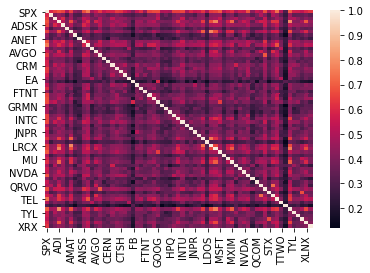

In [19]:
st_cormat = st_close_ret.corr()

sns.heatmap(st_cormat)

In [20]:
st_cormat.head()

,SPX,AAPL,ADBE,ADI,ADSK,AKAM,AMAT,AMD,ANET,ANSS,...,SWKS,TEL,TTWO,TWTR,TXN,TYL,VRSN,WDC,XLNX,XRX
SPX,1.000000,0.594454,0.640472,0.683298,0.653121,0.508136,0.647975,0.447742,0.405457,0.676361,...,0.583891,0.735098,0.498561,0.299533,0.702269,0.572662,0.565424,0.535550,0.589004,0.622795
AAPL,0.594454,1.000000,0.391650,0.451282,0.404948,0.288814,0.449266,0.301571,0.290395,0.420987,...,0.495559,0.443582,0.337278,0.246508,0.466154,0.336545,0.344159,0.342228,0.368228,0.328292
ADBE,0.640472,0.391650,1.000000,0.489951,0.597206,0.377447,0.474976,0.327088,0.381254,0.544977,...,0.385006,0.473604,0.417703,0.286828,0.488523,0.501832,0.426522,0.371542,0.436130,0.388711
ADI,0.683298,0.451282,0.489951,1.000000,0.518988,0.392218,0.668798,0.436903,0.336469,0.510570,...,0.623242,0.619291,0.385259,0.253183,0.790528,0.417567,0.409653,0.487627,0.687649,0.454002
ADSK,0.653121,0.404948,0.597206,0.518988,1.000000,0.403540,0.517180,0.360747,0.386889,0.593243,...,0.467301,0.539521,0.382253,0.293418,0.527280,0.456132,0.451628,0.433908,0.460370,0.418679


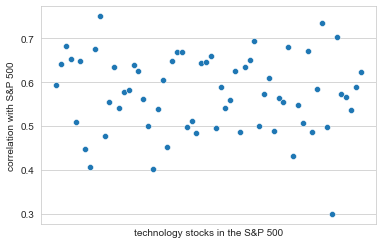

In [21]:
sns.set_style('whitegrid')
spcor = sns.scatterplot(x=st_cormat.columns[1:],y=st_cormat.SPX[1:]);
plt.ylabel('correlation with S&P 500');
plt.xlabel('technology stocks in the S&P 500');
spcor.axes.get_xaxis().set_ticks([]);

Test creating a base capm model.

In [22]:
tech_etf = ['IXN','IGM','IGV','XNTK','XLK','XSD','VGT','RYT','XSW']

etf_daily_close = pd.read_csv('IXN.csv')
etf_daily_close = etf_daily_close[['Date','Close']]
for i in tech_etf[1:]: 
    etf_csv = i +'.csv'
    etf_df = pd.read_csv(etf_csv)[['Date','Close']]
    etf_daily_close = pd.merge(etf_daily_close,etf_df,how='left',left_on='Date',right_on='Date')

pd.read_csv('IXN.csv').head()
etf_daily_close['Date'] = pd.to_datetime(etf_daily_close['Date'])
etf_daily_close.set_index('Date',inplace=True)
etf_daily_close.columns = tech_etf
etf_daily_ret = etf_daily_close.pct_change()[1:]
stETF = st_close_ret.join(etf_daily_ret)
stETF.head()


,SPX,AAPL,ADBE,ADI,ADSK,AKAM,AMAT,AMD,ANET,ANSS,...,XRX,IXN,IGM,IGV,XNTK,XLK,XSD,VGT,RYT,XSW
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,0.003116,0.002618,0.016446,-0.001579,-0.015193,0.029707,-0.007692,0.001031,NaN,-0.022401,...,0.001159,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,0.000546,-0.016971,-0.002122,-0.001898,0.002373,-0.008243,-0.002114,-0.014418,NaN,-0.006645,...,-0.009259,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,0.004001,-0.001328,-0.019405,-0.007921,0.005525,0.000378,-0.010593,-0.010449,NaN,0.002537,...,0.004673,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,0.002882,0.006649,-0.005422,0.005749,0.030612,0.000000,0.038544,-0.004224,NaN,0.006903,...,-0.003488,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-11,0.001747,-0.009247,-0.013083,-0.005716,-0.000381,-0.003399,0.021993,-0.030753,NaN,0.003885,...,0.024504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

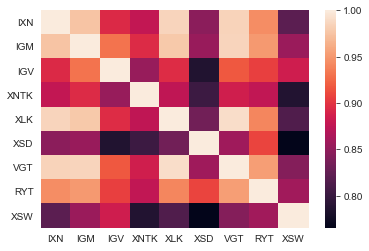

In [23]:
sns.heatmap(etf_daily_ret.corr())

trying in normal CAPM model on MSFT

In [24]:

import statsmodels.api as sm

stETF = st_close_ret.join(etf_daily_ret)

spx = stETF['SPX']
msft = stETF['MSFT']
x = sm.add_constant(spx)
lr = sm.OLS(msft,x)
results = lr.fit()
msft_spx = results.predict(x)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MSFT   R-squared:                       0.481
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     2328.
Date:                Sat, 31 Oct 2020   Prob (F-statistic):               0.00
Time:                        08:19:23   Log-Likelihood:                 7932.8
No. Observations:                2515   AIC:                        -1.586e+04
Df Residuals:                    2513   BIC:                        -1.585e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      1.254      0.210      -0.000       0.001
SPX            1.0688      0.022     48.253      0.000       1.025       1.112
==============================================================================
Omnibus:                      598.950   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            29908.667
Skew:                           0.187   Prob(JB):                         0.00
Kurtosis:                      19.890   Cond. No.                         108.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

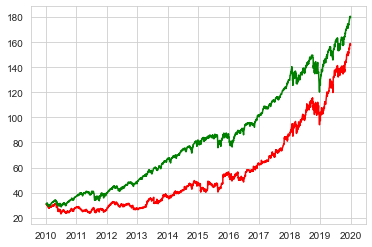

In [25]:
pred_msft = st_close.iloc[0]['MSFT'] * np.cumprod(msft_spx+1)
plt.plot(st_close['MSFT'],'r')
plt.plot(pred_msft,'g')

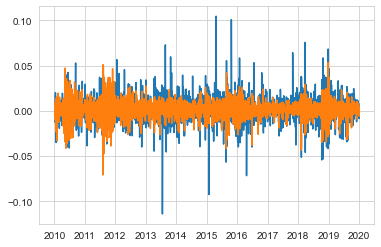

In [26]:
plt.plot(msft)
plt.plot(msft_spx)

In [27]:
x = stETF.loc[:,tech_etf].dropna()
y = stETF.loc[x.index[0]:x.index[-1],:]['MSFT']
#y = st_close_ret.loc[x.index[0],:]['GOOG'].dropna()
#x = st_close_ret.loc[y.index[0],:]['SPX']
x = sm.add_constant(x)
lr = sm.OLS(y,x)
results = lr.fit()
msft_etf = results.predict(x)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MSFT   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.630
Method:                 Least Squares   F-statistic:                     381.6
Date:                Sat, 31 Oct 2020   Prob (F-statistic):               0.00
Time:                        08:19:35   Log-Likelihood:                 6689.9
No. Observations:                2011   AIC:                        -1.336e+04
Df Residuals:                    2001   BIC:                        -1.330e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      1.217      0.224      -0.000       0.001
IXN           -0.0102      0.102     -0.100      0.921      -0.211       0.191
IGM            0.7274      0.120      6.074      0.000       0.493       0.962
IGV            0.4399      0.050      8.743      0.000       0.341       0.539
XNTK          -0.0087      0.031     -0.279      0.780      -0.070       0.052
XLK            0.9794      0.142      6.900      0.000       0.701       1.258
XSD           -0.1279      0.031     -4.117      0.000      -0.189      -0.067
VGT           -0.3365      0.169     -1.989      0.047      -0.668      -0.005
RYT           -0.3925      0.080     -4.916      0.000      -0.549      -0.236
XSW           -0.2158      0.036     -6.025      0.000      -0.286      -0.146
==============================================================================
Omnibus:                      516.236   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            22003.487
Skew:                           0.418   Prob(JB):                         0.00
Kurtosis:                      19.183   Cond. No.                     1.04e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.04e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

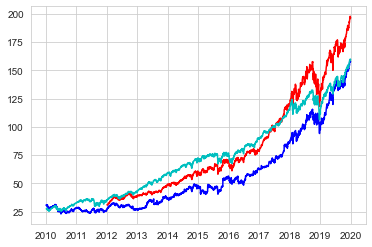

In [29]:
pred_msft_etf = st_close.iloc[0]['MSFT'] * np.cumprod(msft_etf+1)
pred_msft_ind = st_close.loc[pred_msft_etf.index[0]:]['MSFT'].iloc[0] * np.cumprod(msft_spx+1)
plt.plot(pred_msft_etf, 'r')
plt.plot(st_close['MSFT'], 'b')
plt.plot(pred_msft_ind, 'c')

In [30]:
def regress_pca(stock,pca_factors): 
    pca_f = PCA(n_components = 1)
    pca_f.fit(pca_factors)
    features = pca_f.transform(pca_factors)
    features = pd.DataFrame(features,index=pca_factors.index,columns=['etf_pca1'])
    x_pca = sm.add_constant(features)
    y = stock
    lr = sm.OLS(y,x_pca)
    results = lr.fit()
    alpha = results.params[0]
    beta1 = results.params[1]
    res = y - beta1 * x_pca.iloc[:,1] -alpha
    #beta2 = results.params[2]
    return alpha,beta1,res

def calc_ar1(residual): 
    ar1 = ARIMA(residual,order=(1,0,0)).fit()
    ar1_a = ar1.params[0]
    ar1_b = ar1.params[1]
    ar1_res  = ar1.resid
    return ar1_a,ar1_b,ar1_res

def compute_s_score(a,b,r):
    m = r.mean()
    if b > 0: 
        std_r_eq = r.std()/np.sqrt(2 * b)
    else: 
        std_r_eq =  r.std()/-np.sqrt(2 * abs(b))
    s = (r[-1]- m)/std_r_eq
    return s,std_r_eq,m

def calculate_signals(s,b,window): 
    signal = pd.DataFrame(columns = s.columns, index = s.index[window:])
    for i in range(0,s.shape[1]): 
        print('running for'+ " " + s.columns[i])
        curr_s = s.iloc[:,i]
        for j in range(window,s.shape[0]-20):
            if(j%200 == 0): 
                print("currently at iteration: "+ str(j))
            stock = s.iloc[j:j+window,i]
            pca_f = b.iloc[j:j+window,:]
            alpha,beta,res = regress_pca(stock,pca_f)
            ar1_a,ar1_b,ar1_res = calc_ar1(res.mean() - res)
            signal.loc[stock.index[-1],s.columns[i]] = compute_s_score(ar1_a,ar1_b,res)[0]
    return signal
        
    

In [31]:
#test_run
stetf = stETF[stETF['IXN'].notna()]
s = stetf['AAPL']
b = stetf.loc[:,tech_etf]
alpha,beta,residual  = regress_pca(s,b)
a,b,r = calc_ar1(residual)
compute_s_score(a,b,r)

(0.10044314959498775, 0.038970978526508056, -1.9629270051305823e-07)

<AxesSubplot:>

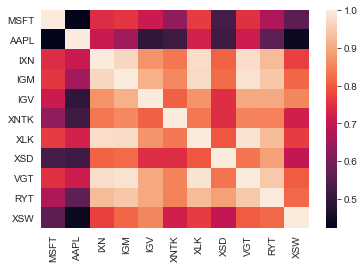

In [17]:
check_cor = stetf[['MSFT','AAPL']]
check_cor = check_cor.join(stetf.loc[:,tech_etf])
corr = check_cor.corr()[['MSFT','AAPL']]
sns.heatmap(check_cor.corr())

In [18]:
s = stetf[['AAPL']]
b = stetf.loc[:,tech_etf]
windows = 60
s_score = calculate_signals(s,b,windows)
s_score = s_score.dropna()
s_score.rename({'AAPL':'s_score'},axis=1,inplace=True)
s_score = s_score.join(stetf['AAPL']+1)

running for AAPL
currently at iteration: 200
currently at iteration: 400
currently at iteration: 600
currently at iteration: 800
currently at iteration: 1000
currently at iteration: 1200
currently at iteration: 1400
currently at iteration: 1600
currently at iteration: 1800


In [ ]:
s = stetf.dropna(axis=1)
b = stetf.loc[:,tech_etf]
windows = 60
s_score_all = calculate_signals(s,b,windows)
s_score_all.to_csv('s_score_all_tech_b.csv')
s_score_all_clean = s_score_all_clean.astype(float)

s_corr = s_score_all_clean.corr()

running for SPX
currently at iteration: 200
currently at iteration: 400
currently at iteration: 600
currently at iteration: 800
currently at iteration: 1000
currently at iteration: 1200
currently at iteration: 1400
currently at iteration: 1600
currently at iteration: 1800
running for AAPL
currently at iteration: 200
currently at iteration: 400
currently at iteration: 600
currently at iteration: 800
currently at iteration: 1000
currently at iteration: 1200
currently at iteration: 1400
currently at iteration: 1600
currently at iteration: 1800
running for ADBE
currently at iteration: 200
currently at iteration: 400
currently at iteration: 600
currently at iteration: 800
currently at iteration: 1000
currently at iteration: 1200
currently at iteration: 1400
currently at iteration: 1600
currently at iteration: 1800
running for ADI
currently at iteration: 200
currently at iteration: 400
currently at iteration: 600
currently at iteration: 800
currently at iteration: 1000
currently at iteration

In [10]:
s_tech = pd.read_csv('s_score_all_tech_b.csv').dropna().dropna(axis=1).set_index('Date')

In [35]:
s_score = pd.DataFrame(s_tech.AAPL).rename({'AAPL':'AAPL_s'},axis=1)
s_score = s_score.join(stetf['AAPL']+1)

In [266]:
def sim_arbitrage(s_score,buy_s,cut_s,cap): 
    daily_cap = []
    long = False
    for i in s_score.iterrows(): 
        curr_d = i[0]
        curr_s = i[1][0]
        curr_r = i[1][1]
        daily_cap.append(cap)
        if long == True: 
            cap = cap * curr_r
            if curr_s > cut_s: 
                long = False

        #elif short == True: 
        #    cap = cap * (((curr_r - 1) * -1) + 1)
        #    if curr_s <= -.5: 
        #        short = False

        if curr_s <= buy_s: 
            long = True
        #elif curr_s > 1.25: 
        #    short = True
        
    daily_cap = pd.DataFrame(daily_cap,index = s_score.index,columns= ['value'])
    daily_ret = daily_cap.pct_change()[1:]
    sharpe = daily_ret.mean()/daily_ret.std()
    sortino = daily_ret.mean()/daily_ret[daily_ret<0].std()
   
    return daily_cap,daily_ret,sharpe,sortino



<AxesSubplot:xlabel='Date'>

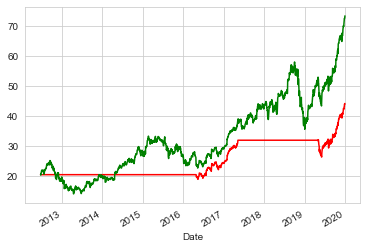

In [267]:
dc,dr,ds,dso = sim_arbitrage(s_score,a_sh[0],a_sh[1],20.38)

test_sh_aapl= dc.join(st_close.AAPL)

test_sh_aapl.value.plot(color='r')
test_sh_aapl.AAPL.plot(color = 'g')

<AxesSubplot:xlabel='Date'>

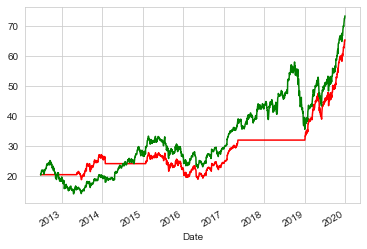

In [268]:
dc,dr,ds,dso = sim_arbitrage(s_score,a_so[0],a_so[1],20.38)

test_so_aapl= dc.join(st_close.AAPL)

test_so_aapl.value.plot(color='r')
test_so_aapl.AAPL.plot(color = 'g')

In [332]:
from itertools import product
import random
def opt_grid_params(s_score):
    metrics = metrics = pd.DataFrame(columns=['cap','mean_ret','std','sharpe','sortino','buy_s','cut_s'])

    
    params = list(product(params_b,params_c))
    params = random.sample(params,60)
    for b in params: 
        dc,dr,ds,dso = sim_arbitrage(s_score,b[0],b[1],1)
        metrics = metrics.append({'cap':dc.value[-1],'mean_ret':dr.mean()[0],'std':dr.std()[0],'sharpe':ds[0],'sortino':dso[0],'buy_s':b[0],'cut_s':b[1]},ignore_index = True)
    metrics_sh = metrics[metrics.sharpe == metrics.sharpe.max()]
    metrics_so = metrics[metrics.sortino == metrics.sortino.max()]
    print(metrics_sh)
    print(metrics_so)
    sh = metrics_sh.iloc[0][['buy_s','cut_s']]
    so = metrics_so.iloc[0][['buy_s','cut_s']]
    return sh,so

In [298]:
train_range = pd.date_range(start = s_tech.index[0], end = "2016-12-31")
s_tech.index = pd.to_datetime(s_tech.index)

s_tech_train = s_tech[s_tech.index.isin(train_range)]
s_tech_test = s_tech.loc[train_range[-1]:]

In [5]:
import pandas as pd
pd.read_csv('s_score_all_tech_b.csv')[60:]

,Date,SPX,AAPL,ADBE,ADI,ADSK,AKAM,AMAT,AMD,ANSS,...,XRX,IXN,IGM,IGV,XNTK,XLK,XSD,VGT,RYT,XSW
60,2012-06-26,-0.521572,0.007895,-0.238680,0.832718,-0.019666,-0.135748,-0.063661,-0.096708,-0.025270,...,-0.162044,-0.091622,-0.601667,0.281540,0.114189,-0.147207,0.232203,-0.122451,0.549773,-0.489030
61,2012-06-27,-0.454807,0.105736,-0.057799,-0.346667,-0.077779,-0.003638,-0.269503,0.023710,0.419414,...,-0.002707,0.151391,0.808957,-0.036472,-0.259249,0.233827,-0.385777,0.424385,-0.870307,0.364923
62,2012-06-28,-1.018738,-0.050227,-0.254720,0.489523,0.020169,-0.086608,-0.579739,-0.140310,0.646332,...,-0.597781,-0.522268,-0.352228,-0.069071,1.346739,-0.241925,-0.547426,-0.117552,2.741125,0.253211
63,2012-06-29,0.180172,0.268554,0.032052,0.354150,-0.079556,-0.073300,0.443574,0.023563,0.250552,...,0.376756,0.226350,0.764642,-0.066819,-0.362811,0.449904,0.719288,0.400562,-1.813973,-1.138021
64,2012-07-02,-0.180870,-0.334974,0.428686,1.283928,0.328118,0.109522,0.995532,-0.090024,0.077362,...,0.074977,-0.055487,-0.407890,0.013725,-0.045219,-0.723790,0.240719,-0.547401,-0.012695,0.217837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1946,2019-12-24,-0.085385,0.023408,-0.012373,-0.134514,0.112564,0.001181,-0.129091,-0.417965,0.151311,...,0.019860,0.435293,0.040937,-0.048579,-0.092905,0.025786,0.281799,0.080841,-0.160011,-0.188079
1947,2019-12-26,0.064962,0.207084,0.041321,0.162304,-0.196910,-0.334608,0.340233,0.284723,0.027616,...,0.022621,-0.365069,-1.805819,-0.080540,0.214353,-0.311023,-0.152280,-0.370259,-1.153119,-0.212157
1948,2019-12-27,-0.035939,0.021676,0.003532,-0.044494,0.168910,-0.302175,-0.036634,0.292314,0.180949,...,0.056414,-0.469805,-0.137718,0.257302,-0.141366,-0.235368,-0.593987,-0.161744,0.285964,-0.256802
1949,2019-12-30,0.108226,0.141934,-0.003249,-0.188364,-0.087051,0.015079,-0.268559,0.201449,0.001037,...,0.077335,0.068510,0.626896,-0.263545,0.635283,-0.239794,0.399298,-0.147335,0.193995,0.057718


In [6]:
pd.read_csv('s_signal_optimal.csv')

,Unnamed: 0,SPX,AAPL,ADBE,ADI,ADSK,AKAM,AMAT,AMD,ANSS,...,XRX,IXN,IGM,IGV,XNTK,XLK,XSD,VGT,RYT,XSW
0,sharpe_opt,"[-1.3000000000000096, 0.35000000000000003]","[-3.200000000000003, 1.9000000000000001]","[-1.6500000000000083, 2.1]","[-1.6500000000000083, 2.4000000000000004]","[-1.7000000000000082, 2.4000000000000004]","[-1.3000000000000096, 2.4000000000000004]","[-2.7000000000000046, 2.0]","[-1.450000000000009, 2.5500000000000003]","[-1.20000000000001, 0.4]",...,"[-1.4000000000000092, 0.8500000000000001]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,sortino_opt,"[-1.6500000000000083, 2.1]","[-1.8000000000000078, 2.8000000000000003]","[-1.0500000000000105, 2.45]","[-1.3500000000000094, 2.25]","[-1.5000000000000089, 2.45]","[-1.3000000000000096, 2.4000000000000004]","[-1.1500000000000101, 2.45]","[-1.1500000000000101, 2.8000000000000003]","[-1.6000000000000085, 1.7000000000000002]",...,"[-1.4000000000000092, 0.8500000000000001]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [333]:
opt_s_tech = pd.DataFrame(columns=s_tech_train.columns, index=('sharpe_opt','sortino_opt'))
for column in s_tech_train:
    print('currently on: ' + str(column))
    s_score = pd.DataFrame(s_tech.AAPL).rename({column: str(column)+"_s"},axis=1)
    s_score = s_score.join(stetf[str(column)]+1)
    curr_sh,curr_so =opt_grid_params(s_score) 
    opt_s_tech[column]  = [list(curr_sh),list(curr_so)]

currently on: SPX
         cap  mean_ret       std    sharpe   sortino  buy_s  cut_s
44  1.351986  0.000163  0.002607  0.062485  0.031744   -1.4   0.85
         cap  mean_ret     std    sharpe   sortino  buy_s  cut_s
48  1.942509  0.000379  0.0074  0.051161  0.057724  -1.05   2.15
currently on: AAPL
         cap  mean_ret       std    sharpe   sortino  buy_s  cut_s
6   2.166345  0.000428  0.006259  0.068441  0.046376  -3.10   2.50
11  2.166345  0.000428  0.006259  0.068441  0.046376  -2.90   2.15
15  2.166345  0.000428  0.006259  0.068441  0.046376  -2.70   2.95
17  2.166345  0.000428  0.006259  0.068441  0.046376  -2.90   2.60
47  2.166345  0.000428  0.006259  0.068441  0.046376  -3.15   2.95
54  2.166345  0.000428  0.006259  0.068441  0.046376  -2.85   2.25
         cap  mean_ret       std    sharpe   sortino  buy_s  cut_s
35  3.211703  0.000677  0.010969  0.061751  0.063204  -1.80    2.9
37  3.211703  0.000677  0.010969  0.061751  0.063204  -1.75    1.7
currently on: ADBE
         c

In [412]:
daily_signal_sh = pd.DataFrame(columns = s_tech_test.columns, index = s_tech_test.index)
daily_signal_so = pd.DataFrame(columns = s_tech_test.columns, index = s_tech_test.index)
for column in s_tech_test: 
    sh_buy = s_tech[s_tech[column]<=opt_s_tech[column][0][0]][column]
    so_buy = s_tech[s_tech[column]<=opt_s_tech[column][1][0]][column]
    sh_sell = s_tech[s_tech[column]>=opt_s_tech[column][0][1]][column]
    so_sell = s_tech[s_tech[column]>=opt_s_tech[column][1][1]][column]
    daily_signal_sh.loc[daily_signal_sh.index.isin(sh_buy.index),column] = "BUY"
    daily_signal_sh.loc[daily_signal_sh.index.isin(sh_sell.index),column] = "SELL"
    daily_signal_so.loc[daily_signal_so.index.isin(so_buy.index),column] = "BUY"
    daily_signal_so.loc[daily_signal_so.index.isin(so_sell.index),column] = "SELL"